Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.3.1


# LeNet-5 MNIST Digits Classifier

This notebook implements the classic LeNet-5 convolutional network [1] and applies it to MNIST digit classification. The basic architecture is shown in the figure below:

![](../images/lenet/lenet-5_1.jpg)



LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a very simple architecture (by modern standards). In total, LeNet-5 consists of only 7 layers. 3 out of these 7 layers are convolutional layers (C1, C3, C5), which are connected by two average pooling layers (S2 & S4). The penultimate layer is a fully connexted layer (F6), which is followed by the final output layer. The additional details are summarized below:

- All convolutional layers use 5x5 kernels with stride 1.
- The two average pooling (subsampling) layers are 2x2 pixels wide with stride 1.
- Throughrout the network, tanh sigmoid activation functions are used. (**In this notebook, we replace these with ReLU activations**)
- The output layer uses 10 custom Euclidean Radial Basis Function neurons for the output layer. (**In this notebook, we replace these with softmax activations**)
- The input size is 32x32; here, we rescale the MNIST images from 28x28 to 32x32 to match this input dimension. Alternatively, we would have to change the 
achieve error rate below 1% on the MNIST data set, which was very close to the state of the art at the time (produced by a boosted ensemble of three LeNet-4 networks).


### References

- [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998.

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
DEVICE = "cuda:1"
GRAYSCALE = True

### MNIST Dataset

In [4]:
##########################
### MNIST DATASET
##########################

resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=resize_transform,
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=resize_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])


In [5]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [6]:
##########################
### MODEL
##########################


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [7]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [8]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0469 | Cost: 2.3055
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.5465
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.3708
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.3407
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.1298
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.1856
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.0940
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.1851
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.1425
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.0623
Epoch: 001/010 | Train: 96.658%
Time elapsed: 0.30 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.0659
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.1018
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0810
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.1708
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.0639
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.0769
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.0425
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0942
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.0303
Epoch: 002/010 | Batch 0450/0469 

## Evaluation

In [9]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 98.93%


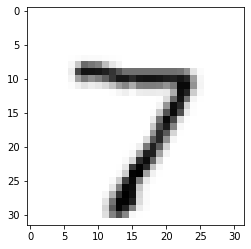

In [10]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
    
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [11]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%


In [12]:
%watermark -iv

torch       1.3.1
numpy       1.17.4
matplotlib  3.1.0
torchvision 0.4.2
pandas      0.24.2
PIL.Image   6.2.1

